##  This notebook is used to adjust Uganda National Communication emissions pathways for biomass emissions reallocation to energy

- Iterative notebook--first pass is on Thursday, August 14 2025
- Use results from ```emission_targets_uganda_inventory_aggregates``` notebook to reassign emissions while preserving net balance

In [2]:
# can comment out warnings.filterwarnings if you want to see warnings
import warnings
warnings.filterwarnings("ignore")

# only if you don't have the environment set up and you're lazy like me
import sys
dir_git = "/Users/usuario/git/sisepuede"
if dir_git not in sys.path:
    sys.path.append(dir_git)

import sisepuede.manager.sisepuede_examples as sxl
import sisepuede.manager.sisepuede_file_structure as sfs
import sisepuede.manager.sisepuede_models as sm
import sisepuede.plotting.plots as spp
import sisepuede.utilities._toolbox as sf

import importlib
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import pandas as pd
import pathlib
import time
from typing import *

plt.style.use("dark_background", )


logger = None



In [35]:

# instantiate sispeuede classes
examples = sxl.SISEPUEDEExamples()
file_struct = sfs.SISEPUEDEFileStructure()

# derivate info
df_examples = examples("input_data_frame")
matt = file_struct.model_attributes

In [257]:
# fields
_FIELD_ADJ_FRAC_ALLOCATIONS_INEN = "frac_allocation_inen"
_FIELD_ADJ_FRAC_ALLOCATIONS_SCOE = "frac_allocation_scoe"
_FIELD_ADJ_FRST_SEQ = "forest_seq_mt_co2e"
_FIELD_ADJ_REMOVALS_TO_ALLOCATE = "total_removals_to_reallocate_mt_co2e"
_FIELD_GAS = "Gas"
_FIELD_SECTOR = "Sector"
_FIELD_SOURCE = "Source"
_FIELD_SUBSECTOR = "Subsector"
_FIELD_YEAR = "Year"
_FIELD_VALUE = "Value"

# setup paths
_PATH_CUR = pathlib.Path(os.path.abspath(os.getcwd()))
_PATH_DATA = _PATH_CUR.joinpath("data")
_PATH_EMISSION_TARGETS_AGGREGATE = _PATH_DATA.joinpath("emission_targets_uganda_inventory_aggregates.csv")
_PATH_EMISSION_TARGETS_AGGREGATE_WORKBOOK = _PATH_DATA.joinpath("emission_targets_uganda_inventory_aggregates.xlsx")
_PATH_EMISSION_TARGETS_DECOMPOSED = _PATH_DATA.joinpath("emission_targets_uganda_ghg_inventory.csv")
if not _PATH_EMISSION_TARGETS_DECOMPOSED.is_file():
    raise RuntimeError(f"path to emissions targets '{_PATH_EMISSION_TARGETS_DECOMPOSED}' not found")
    
# output paths
_PATH_EMISSION_TARGETS_DECOMPOSED_ADJUSTED = _PATH_DATA.joinpath("emission_targets_uganda_ghg_inventory_biomass_adjusted.csv")
_PATH_EMISSION_TARGETS_DECOMPOSED_ADJUSTED_MAPPED_TO_WB = _PATH_DATA.joinpath("emission_targets_uganda_ghg_inventory_biomass_adjusted_mapped_to_wbcsc.csv")



# sectors and subsectors
_SECTOR_AFOLU = "AFOLU"
_SECTOR_ENERGY = "Energy"
_SUBSECTOR_FRST = "Forest land"
_SUBSECTOR_INEN = "Manufacturing Industries and Construction"
_SUBSECTOR_SCOE = "Other (Residential, Commercial, Institution)"


In [204]:
# get data from National Communication 3
df_agg = pd.read_csv(_PATH_EMISSION_TARGETS_AGGREGATE, )
df_pathways = pd.read_csv(_PATH_EMISSION_TARGETS_DECOMPOSED, )


df_pathways = (
    df_pathways[
        ~df_pathways[_FIELD_SOURCE].isin(["WB CSC"])
    ]
    .get(
        [
            _FIELD_SECTOR,
            _FIELD_SUBSECTOR,
            _FIELD_GAS,
            _FIELD_YEAR,
            _FIELD_VALUE
        ]
    )
    .reset_index(drop = True, )
)

"""
# filter out screwy rows
df_pathways = df_pathways[
    ~(
        df_pathways[_FIELD_SECTOR].isin([_SECTOR_ENERGY])
        & df_pathways[_FIELD_SUBSECTOR].isin([_SUBSECTOR_SCOE])
    )
]
"""

# get adjustment info
df_adjustments = (
    pd.read_excel(
        _PATH_EMISSION_TARGETS_AGGREGATE_WORKBOOK, 
        sheet_name = "for_trajectory_modification",
    )
    .rename(columns = {"year": _FIELD_YEAR, })
)

In [206]:
# forestry indices
inds_frst = (
    df_pathways[_FIELD_SECTOR].isin([_SECTOR_AFOLU])
    & df_pathways[_FIELD_SUBSECTOR].isin([_SUBSECTOR_FRST])
)

# inen indices
inds_inen = (
    df_pathways[_FIELD_SECTOR].isin([_SECTOR_ENERGY])
    & df_pathways[_FIELD_SUBSECTOR].isin([_SUBSECTOR_INEN])
)

# scoe indices
inds_scoe = (
    df_pathways[_FIELD_SECTOR].isin([_SECTOR_ENERGY])
    & df_pathways[_FIELD_SUBSECTOR].isin([_SUBSECTOR_SCOE])
)

inds_other = ~(inds_frst | inds_inen | inds_scoe)

# pathways by subsector
df_pathways_frst = df_pathways[inds_frst]
df_pathways_inen = df_pathways[inds_inen]

# deal with potential zeros in SCOE
df_pathways_scoe = df_pathways[inds_scoe]
if inds_scoe.sum() == 0:
    df_pathways_scoe = df_pathways_inen.copy()
    df_pathways_scoe[_FIELD_VALUE] = 0
    df_pathways_scoe[_FIELD_SUBSECTOR] = _SUBSECTOR_SCOE


##  Set new FRST

- use direct outputs from SISEPUEDE for this estimate (we don't have any record of what the annual sequestration is)


In [208]:

df_pathways_frst_new = (
    pd.merge(
        df_pathways_frst,
        df_adjustments.get([_FIELD_YEAR, _FIELD_ADJ_FRST_SEQ]),
        how = "left",
    )
    .interpolate()
    .drop(columns = _FIELD_VALUE)
    .rename(columns = {_FIELD_ADJ_FRST_SEQ: _FIELD_VALUE}, )
)

# Get reallocation function
- use factors for biomass burning from SISEPUEDE + GWPs

In [215]:
##  SETUP SISEPUEDE ELEMENTS

# category for solid biomass
_CAT_ENFU_BIOMASS = "fuel_biomass"

# stationary combustion factors
modvar_sef_ch4 = matt.get_variable(":math:\\text{CH}_4 Stationary Combustion Emission Factor")
modvar_sef_co2 = matt.get_variable(":math:\\text{CO}_2 Combustion Emission Factor")
modvar_sef_n2o = matt.get_variable(":math:\\text{N}_2\\text{O} Stationary Combustion Emission Factor")

# fields
field_bmass_ch4 = modvar_sef_ch4.build_fields(category_restrictions = _CAT_ENFU_BIOMASS)
field_bmass_co2 = modvar_sef_co2.build_fields(category_restrictions = _CAT_ENFU_BIOMASS)
field_bmass_n2o = modvar_sef_n2o.build_fields(category_restrictions = _CAT_ENFU_BIOMASS)
_FIELDS_GAS_ORD = [field_bmass_ch4, field_bmass_co2, field_bmass_n2o]

# global warming potential
gwp_ch4 = matt.get_gwp("ch4")
gwp_co2 = matt.get_gwp("co2") 
gwp_n2o = matt.get_gwp("n2o") 
_GWP_SCALARS_ORD = np.array([gwp_ch4, gwp_co2, gwp_n2o])

# fractional allocation of GHGs
_VEC_FRACTIONAL_ALLOCATION_GHGS = sf.check_row_sums(
    df_examples.get(_FIELDS_GAS_ORD).to_numpy()*_GWP_SCALARS_ORD,
    thresh_correction = None,
)[0, :]


def reallocate(
    df_pathway: pd.DataFrame,
    df_adjustments: pd.DataFrame,
    field_adjustment_frac: str,
    field_adjustment_biomass: str = _FIELD_ADJ_REMOVALS_TO_ALLOCATE,
) -> pd.DataFrame:
    """Get the emissions estimates from reallocation array and assign 
    """

    fields_ind = [_FIELD_SECTOR, _FIELD_SUBSECTOR, _FIELD_YEAR]
    fields_gases = sorted(list(df_pathway[_FIELD_GAS].unique()))
    df_out = sf.pivot_df_clean(
        df_pathway,
        fields_column = [_FIELD_GAS],
        fields_value = [_FIELD_VALUE],
    )

    # in case it's scoe--assume it's all biomass
    if (len(fields_gases) == 1) & ("All GHG" in fields_gases):

        fields_gases = ["CH4", "CO2", "N2O"]
        arr_new_vals = sf.do_array_mult(
            df_out["All GHG"].values,
            _VEC_FRACTIONAL_ALLOCATION_GHGS
        )
    
        df_out[fields_gases] = arr_new_vals
        df_out = df_out.drop(columns = ["All GHG"])
        

    ##  GET PRIMARY ALLOCATION 
        
    # get total to reallocate
    total_co2e_allocated = np.prod(
        df_adjustments[[field_adjustment_biomass, field_adjustment_frac]],
        axis = 1,
    )

    # merge into years and interpolate
    df_merge = df_adjustments[[_FIELD_YEAR]].copy()
    df_merge[field_adjustment_frac] = total_co2e_allocated
    df_merge = (
        pd.merge(
            df_out[[_FIELD_YEAR]],
            df_merge,
            how = "left"
        )
        .interpolate()
    )

    # now, divide up by gas using _VEC_FRACTIONAL_ALLOCATION_GHGS (above)
    arr_allocated_by_gas = sf.do_array_mult(
        df_merge[field_adjustment_frac].to_numpy(),
        _VEC_FRACTIONAL_ALLOCATION_GHGS
    )

    arr_allocated_by_gas += df_out[fields_gases].to_numpy()
    df_out[fields_gases] = arr_allocated_by_gas
    df_out = df_out.melt(
        id_vars = [_FIELD_SECTOR, _FIELD_SUBSECTOR, _FIELD_YEAR],
        value_vars = fields_gases,
        value_name = _FIELD_VALUE,
        var_name = _FIELD_GAS,
    )
    
    return df_out


df_reallocated_inen = reallocate(
    df_pathways_inen,
    df_adjustments,
    _FIELD_ADJ_FRAC_ALLOCATIONS_INEN,
)

df_reallocated_scoe = reallocate(
    df_pathways_scoe,
    df_adjustments,
    _FIELD_ADJ_FRAC_ALLOCATIONS_SCOE,
)

# Combine everything

In [218]:
df_pathways_out = pd.concat(
    [
        df_pathways[inds_other],
        df_pathways_frst_new,
        df_reallocated_inen,
        df_reallocated_scoe
    ]
)

df_pathways_out[_FIELD_SOURCE] = "National Communication 3"

# eliminate screwy rows
df_pathways_out = (
    df_pathways_out[
        df_pathways_out[_FIELD_VALUE] < 1000
    ]
    .sort_values(by = [_FIELD_SECTOR, _FIELD_SUBSECTOR, _FIELD_GAS, _FIELD_YEAR])
    .reset_index(drop = True, )
)



In [219]:
df_pathways_out.to_csv(
    _PATH_EMISSION_TARGETS_DECOMPOSED_ADJUSTED,
    encoding = "UTF-8",
    index = None,
)

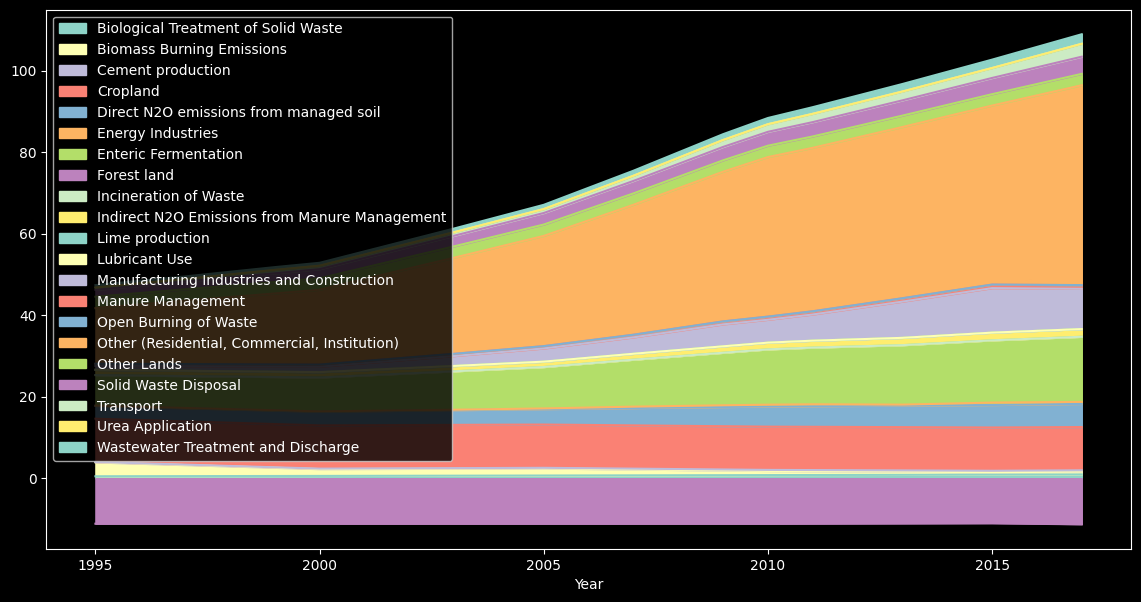

In [354]:
fig, ax = plt.subplots(figsize = (14, 7))

(
    sf.pivot_df_clean(
        df_pathways_out
        .get([_FIELD_SUBSECTOR, _FIELD_YEAR, _FIELD_VALUE])
        .groupby([_FIELD_SUBSECTOR, _FIELD_YEAR])
        .sum()
        .reset_index(),
        fields_column = [_FIELD_SUBSECTOR],
        fields_value = [_FIELD_VALUE],
    )
    .plot
    .area(
        ax = ax,
        x = _FIELD_YEAR, 
    )
)

ax.legend(loc = "upper left")

In [355]:
df_adj = (
    df_pathways_out[[_FIELD_VALUE, _FIELD_YEAR]]
    .groupby([_FIELD_YEAR])
    .sum()
    .rename(columns = {_FIELD_VALUE: "mt_co2e_total_w_biomass_adjusted"})
)

df_orig = (
    df_pathways[[_FIELD_VALUE, _FIELD_YEAR]]
    .groupby([_FIELD_YEAR])
    .sum()
    .rename(columns = {_FIELD_VALUE: "mt_co2e_total_original"})
)

df_compare = df_adj.join(df_orig)
df_compare["diff"] = np.round(
    np.abs(df_compare["mt_co2e_total_original"] - df_compare["mt_co2e_total_w_biomass_adjusted"]),
    decimals = 6,
)
df_compare

,mt_co2e_total_w_biomass_adjusted,mt_co2e_total_original,diff
Year,,,
1995,36.207028,36.207028,0.0
1996,37.275568,37.275568,0.0
1997,38.344108,38.344108,0.0
1998,39.484694,39.484694,0.0
1999,40.625280,40.625280,0.0
2000,41.684811,41.684811,0.0
2001,44.489199,44.489199,0.0
2002,47.291210,47.291210,0.0
2003,50.093220,50.093220,0.0


# Attempt a mapping of National Commuication cateogries to WB CSC categories

In [439]:
df_cw_wb_to_comm = pd.read_csv(_PATH_DATA.joinpath("categories_wb_to_national_communication.csv"))
dict_map_wc_to_comm = sf.build_dict(df_cw_wb_to_comm[["cats_inv", "cats_wb_1"]])
_SOURCE_NEW = "National Communication -- Mapped to WB CSC Categories"

In [454]:

df_pathways_out_mapped_wb = df_pathways_out.copy()
df_pathways_out_mapped_wb[_FIELD_SUBSECTOR] = df_pathways_out_mapped_wb[_FIELD_SUBSECTOR].replace(dict_map_wc_to_comm)
df_pathways_out_mapped_wb[_FIELD_SOURCE] = _SOURCE_NEW

# group and sum
df_pathways_out_mapped_wb = (
    df_pathways_out_mapped_wb
    .groupby([_FIELD_SECTOR, _FIELD_SUBSECTOR, _FIELD_GAS, _FIELD_YEAR, _FIELD_SOURCE])
    .sum()
    .reset_index()
)

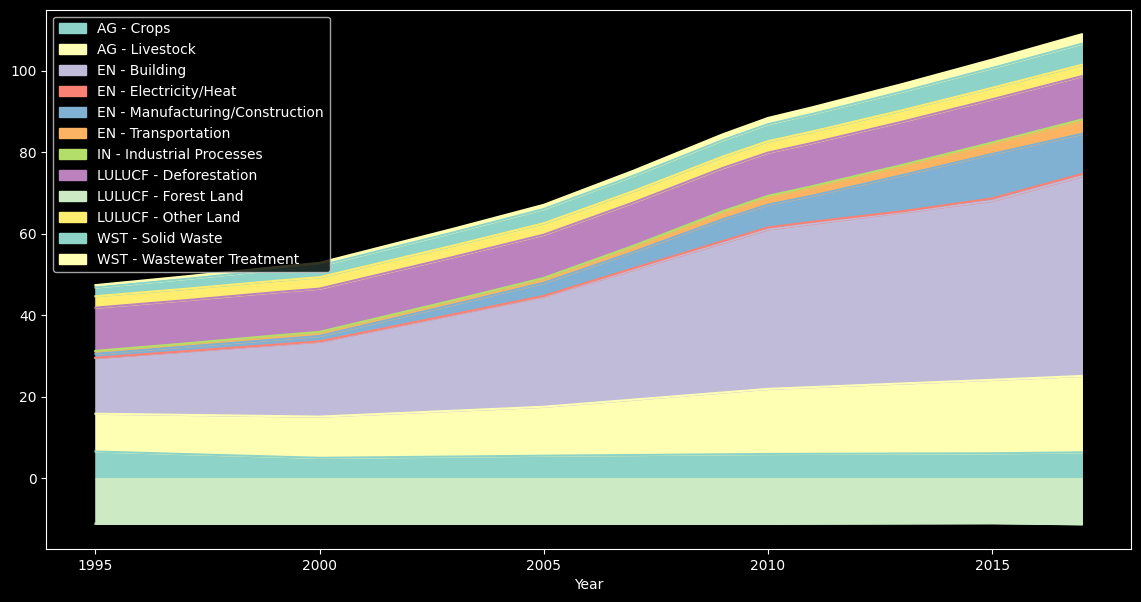

In [455]:
fig, ax = plt.subplots(figsize = (14, 7))

(
    sf.pivot_df_clean(
        df_pathways_out_mapped_wb
        .get([_FIELD_SUBSECTOR, _FIELD_YEAR, _FIELD_VALUE])
        .groupby([_FIELD_SUBSECTOR, _FIELD_YEAR])
        .sum()
        .reset_index(),
        fields_column = [_FIELD_SUBSECTOR],
        fields_value = [_FIELD_VALUE],
    )
    .plot
    .area(
        ax = ax,
        x = _FIELD_YEAR, 
    )
)

ax.legend(loc = "upper left")

# Need to break out IPPU by gas

In [456]:
df_pathways0 = pd.read_csv(_PATH_EMISSION_TARGETS_DECOMPOSED, )

In [457]:


# use WB CSC gas fractions to disaggreate 
df_wide = sf.pivot_df_clean(
    (
        df_pathways0[
            df_pathways0[_FIELD_SOURCE].isin(["WB CSC"])
            & df_pathways0[_FIELD_SECTOR].isin(["Industrial Processes"])
        ]
        .get([_FIELD_GAS, _FIELD_YEAR, _FIELD_VALUE])
        .groupby([_FIELD_GAS, _FIELD_YEAR])
        .sum()
        .reset_index()
    ),
    fields_column = [_FIELD_GAS],
    fields_value = [_FIELD_VALUE]
)

FIELDS_GAS_IPPU = [x for x in df_wide.columns if x != _FIELD_YEAR]
arr_fracs_by_gas = sf.check_row_sums(
    df_wide[FIELDS_GAS_IPPU].to_numpy(),
    thresh_correction = None,
)
df_wide[FIELDS_GAS_IPPU] = arr_fracs_by_gas


# get the component
inds_ippu = df_pathways_out_mapped_wb[_FIELD_SUBSECTOR].isin(["IN - Industrial Processes"])
inds_not_ippu = ~inds_ippu
df_ippu = df_pathways_out_mapped_wb[inds_ippu]

gasses_ippu = df_ippu[_FIELD_GAS].unique()
if not ((len(gasses_ippu) == 1) and ("All GHG" in gasses_ippu)):
    raise RuntimeError("Review the gasses in df_ippu; may not be only All GHG")



# split out the gasses
df_ippu_split = (
    pd.merge(
        df_ippu[[_FIELD_YEAR, _FIELD_VALUE]],
        df_wide,
        how = "outer"
    )
    .dropna(
        subset = [_FIELD_VALUE]
    )
    .bfill()
)


arr_ippu_split = (
    df_ippu_split[FIELDS_GAS_IPPU].to_numpy().transpose() 
    * df_ippu_split[_FIELD_VALUE].to_numpy()
).transpose()

df_ippu_split[FIELDS_GAS_IPPU] = arr_ippu_split
df_ippu_split = (
    df_ippu_split
    .drop(columns = _FIELD_VALUE)
    .melt(
        id_vars = [_FIELD_YEAR],
        value_vars = FIELDS_GAS_IPPU,
        value_name = _FIELD_VALUE,
        var_name = _FIELD_GAS
    )
)

df_ippu_split[_FIELD_SECTOR] = str(df_ippu[_FIELD_SECTOR].iloc[0])
df_ippu_split[_FIELD_SUBSECTOR] = str(df_ippu[_FIELD_SUBSECTOR].iloc[0])
df_ippu_split[_FIELD_SOURCE] = str(df_ippu[_FIELD_SOURCE].iloc[0])



# Adjust the All GHG in Solid Waste

### In National Communication 3, page 74, we see that these emissions are associated with $\text{CH}_4$:

####  _2.5.3.1 Trends of Emissions from Solid Waste Disposal_
_The emission from the solid wastes emanates from the biodegradable fraction of the solid wastes.
At the national level, garden and back yard wastes, food and paper constitute over 80% of solid
wastes in Uganda. The emissions from the solid waste disposal more than doubled; increasing
from 1,672 Gg CO2 eq in 1995 to 4208 Gg CO2 eq in 2017 (Figure 2.10). The time series for CH4
emissions from solid waste._


In [458]:
df_waste_split = df_pathways0[
    df_pathways0[_FIELD_SOURCE].isin(["National Communication 3"])
    #& df_pathways0[_FIELD_SUBSECTOR].isin(["Solid Waste Disposal"])
    & df_pathways0[_FIELD_GAS].isin(["All GHG"])
    & df_pathways0[_FIELD_SECTOR].isin(["Waste"])
]
df_waste_split[_FIELD_SUBSECTOR] = df_waste_split[_FIELD_SUBSECTOR].replace(dict_map_wc_to_comm)
df_waste_split[_FIELD_GAS] = "CH4"
df_waste_split[_FIELD_SOURCE] = _SOURCE_NEW


In [459]:
sf.pivot_df_clean(
    (
        df_pathways0[
            df_pathways0[_FIELD_SOURCE].isin(["WB CSC"])
            & df_pathways0[_FIELD_SUBSECTOR].isin(["WST - Wastewater Treatment"])
        ]
        .get([_FIELD_GAS, _FIELD_YEAR, _FIELD_VALUE])
        .groupby([_FIELD_GAS, _FIELD_YEAR])
        .sum()
        .reset_index()
    ),
    fields_column = [_FIELD_GAS],
    fields_value = [_FIELD_VALUE]
)

,Year,CH4,N2O
0,2000,1.554825,0.199830
1,2001,1.604752,0.206610
2,2002,1.659611,0.222388
3,2003,1.716214,0.232901
4,2004,1.775549,0.244383
5,2005,1.835395,0.246347
6,2006,1.895068,0.252070
7,2007,1.958001,0.260940
8,2008,2.023474,0.277511
9,2009,2.092442,0.299828


In [460]:


# use WB CSC gas fractions to disaggreate 
df_wide = sf.pivot_df_clean(
    (
        df_pathways0[
            df_pathways0[_FIELD_SOURCE].isin(["WB CSC"])
            & df_pathways0[_FIELD_SECTOR].isin(["Industrial Processes"])
        ]
        .get([_FIELD_GAS, _FIELD_YEAR, _FIELD_VALUE])
        .groupby([_FIELD_GAS, _FIELD_YEAR])
        .sum()
        .reset_index()
    ),
    fields_column = [_FIELD_GAS],
    fields_value = [_FIELD_VALUE]
)

FIELDS_GAS_IPPU = [x for x in df_wide.columns if x != _FIELD_YEAR]
arr_fracs_by_gas = sf.check_row_sums(
    df_wide[FIELDS_GAS_IPPU].to_numpy(),
    thresh_correction = None,
)
df_wide[FIELDS_GAS_IPPU] = arr_fracs_by_gas


# get the component
inds_ippu = df_pathways_out_mapped_wb[_FIELD_SUBSECTOR].isin(["IN - Industrial Processes"])
inds_not_ippu = ~inds_ippu
df_ippu = df_pathways_out_mapped_wb[inds_ippu]

gasses_ippu = df_ippu[_FIELD_GAS].unique()
if not ((len(gasses_ippu) == 1) and ("All GHG" in gasses_ippu)):
    raise RuntimeError("Review the gasses in df_ippu; may not be only All GHG")



# split out the gasses
df_ippu_split = (
    pd.merge(
        df_ippu[[_FIELD_YEAR, _FIELD_VALUE]],
        df_wide,
        how = "outer"
    )
    .dropna(
        subset = [_FIELD_VALUE]
    )
    .bfill()
)


arr_ippu_split = (
    df_ippu_split[FIELDS_GAS_IPPU].to_numpy().transpose() 
    * df_ippu_split[_FIELD_VALUE].to_numpy()
).transpose()

df_ippu_split[FIELDS_GAS_IPPU] = arr_ippu_split
df_ippu_split = (
    df_ippu_split
    .drop(columns = _FIELD_VALUE)
    .melt(
        id_vars = [_FIELD_YEAR],
        value_vars = FIELDS_GAS_IPPU,
        value_name = _FIELD_VALUE,
        var_name = _FIELD_GAS
    )
)

df_ippu_split[_FIELD_SECTOR] = str(df_ippu[_FIELD_SECTOR].iloc[0])
df_ippu_split[_FIELD_SUBSECTOR] = str(df_ippu[_FIELD_SUBSECTOR].iloc[0])
df_ippu_split[_FIELD_SOURCE] = str(df_ippu[_FIELD_SOURCE].iloc[0])



# create fake 0 emission FGTV component

In [461]:

df_fgtv_fake = df_ippu_split[
    df_ippu_split[_FIELD_GAS].isin(["CO2"])
].copy()
df_fgtv_fake[_FIELD_GAS] = "CH4"
df_fgtv_fake[_FIELD_SECTOR] = _SECTOR_ENERGY
df_fgtv_fake[_FIELD_SUBSECTOR] = "EN - Fugitive Emissions"
df_fgtv_fake[_FIELD_VALUE] = 0.0
df_fgtv_fake



,Year,Gas,Value,Sector,Subsector,Source
0,1995,CH4,0.0,Energy,EN - Fugitive Emissions,National Communication -- Mapped to WB CSC Cat...
1,1996,CH4,0.0,Energy,EN - Fugitive Emissions,National Communication -- Mapped to WB CSC Cat...
2,1997,CH4,0.0,Energy,EN - Fugitive Emissions,National Communication -- Mapped to WB CSC Cat...
3,1998,CH4,0.0,Energy,EN - Fugitive Emissions,National Communication -- Mapped to WB CSC Cat...
4,1999,CH4,0.0,Energy,EN - Fugitive Emissions,National Communication -- Mapped to WB CSC Cat...
5,2000,CH4,0.0,Energy,EN - Fugitive Emissions,National Communication -- Mapped to WB CSC Cat...
6,2001,CH4,0.0,Energy,EN - Fugitive Emissions,National Communication -- Mapped to WB CSC Cat...
7,2002,CH4,0.0,Energy,EN - Fugitive Emissions,National Communication -- Mapped to WB CSC Cat...
8,2003,CH4,0.0,Energy,EN - Fugitive Emissions,National Communication -- Mapped to WB CSC Cat...
9,2004,CH4,0.0,Energy,EN - Fugitive Emissions,National Communication -- Mapped to WB CSC Cat...


# Recombine DataFrame


In [462]:

# ok 
fields_group = [_FIELD_SECTOR, _FIELD_SUBSECTOR, _FIELD_GAS, _FIELD_YEAR]
df_pathways_out_mapped_wb = (
    pd.concat(
        [
            df_pathways_out_mapped_wb[
                ~df_pathways_out_mapped_wb[_FIELD_GAS].isin(["CO", "NOx", "All GHG"])
                & inds_not_ippu
            ],
            df_ippu_split,
            df_fgtv_fake,
            df_waste_split.get(df_pathways_out_mapped_wb.columns)
        ],
    )
    .groupby(fields_group)
    .sum()
    .reset_index()
    .sort_values(by = [_FIELD_SECTOR, _FIELD_SUBSECTOR, _FIELD_GAS, _FIELD_YEAR])
    .reset_index(drop = True, )
)

In [463]:
(
    df_pathways_out_mapped_wb[df_pathways_out_mapped_wb[_FIELD_SUBSECTOR].isin(["WST - Solid Waste"])]
    .get([_FIELD_YEAR, _FIELD_VALUE])
    .groupby([_FIELD_YEAR])
    .sum()
)

,Value
Year,
1995,2.157598
1996,2.290561
1997,2.423524
1998,2.556487
1999,2.689450
2000,2.822413
2001,2.957535
2002,3.092657
2003,3.227780


In [468]:
df_pathways_out_mapped_wb[
    df_pathways_out_mapped_wb[_FIELD_SUBSECTOR].isin(["WST - Solid Waste"])
    & df_pathways_out_mapped_wb[_FIELD_YEAR].isin([2010])
]

,Sector,Subsector,Gas,Year,Source,Value
544,Waste,WST - Solid Waste,CH4,2010,National Communication -- Mapped to WB CSC Cat...,3.890218
567,Waste,WST - Solid Waste,CO2,2010,National Communication -- Mapped to WB CSC Cat...,0.004221
590,Waste,WST - Solid Waste,N2O,2010,National Communication -- Mapped to WB CSC Cat...,0.286377


## Comparison


In [465]:
df_adj = (
    df_pathways_out_mapped_wb[[_FIELD_VALUE, _FIELD_YEAR]]
    .groupby([_FIELD_YEAR])
    .sum()
    .rename(columns = {_FIELD_VALUE: "mt_co2e_total_w_biomass_adjusted_and_wb_cats"})
)

df_orig = (
    df_pathways[[_FIELD_VALUE, _FIELD_YEAR]]
    .groupby([_FIELD_YEAR])
    .sum()
    .rename(columns = {_FIELD_VALUE: "mt_co2e_total_original"})
)

df_compare = df_adj.join(df_orig)
df_compare["diff"] = np.round(
    np.abs(df_compare["mt_co2e_total_original"] - df_compare["mt_co2e_total_w_biomass_adjusted_and_wb_cats"]),
    decimals = 6,
)
df_compare

,mt_co2e_total_w_biomass_adjusted_and_wb_cats,mt_co2e_total_original,diff
Year,,,
1995,34.472028,36.207028,1.735
1996,35.887568,37.275568,1.388
1997,37.303108,38.344108,1.041
1998,38.790694,39.484694,0.694
1999,40.278280,40.625280,0.347
2000,41.684811,41.684811,0.000
2001,44.489199,44.489199,0.000
2002,47.291210,47.291210,0.000
2003,50.093220,50.093220,0.000


In [469]:
df_pathways_out_mapped_wb.to_csv(
    _PATH_EMISSION_TARGETS_DECOMPOSED_ADJUSTED_MAPPED_TO_WB,
    encoding = "UTF-8",
    index = None,
)
